# Lab 2

Getting the best models on the planet to generate an SVG

Inspired by the legendary Simon Willison's Pelican riding a bike test

In [1]:
# imports

import os
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import Markdown, display, SVG
from datetime import datetime
from litellm import acompletion
import asyncio
import xml.etree.ElementTree as ET
import time

In [2]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')
deepseek_api_key = os.getenv('DEEPSEEK_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')
grok_api_key = os.getenv('GROK_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set (and this is optional)")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:2]}")
else:
    print("Google API Key not set (and this is optional)")

if deepseek_api_key:
    print(f"DeepSeek API Key exists and begins {deepseek_api_key[:3]}")
else:
    print("DeepSeek API Key not set (and this is optional)")

if groq_api_key:
    print(f"Groq API Key exists and begins {groq_api_key[:4]}")
else:
    print("Groq API Key not set (and this is optional)")

if grok_api_key:
    print(f"Grok API Key exists and begins {grok_api_key[:4]}")
else:
    print("Grok API Key not set (and this is optional)")

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AI
DeepSeek API Key exists and begins sk-
Groq API Key exists and begins gsk_
Grok API Key exists and begins xai-


## Connecting to Python Client libraries

We call Cloud APIs by making REST calls to an HTTP endpoint, passing in our keys.

For convenience, the labs like OpenAI have provided lightweight python client libraries that make the HTTP calls for us.

In [3]:
# Connect to OpenAI client library
# A thin wrappes around calls to REST endpoints

openai = OpenAI()

# For Gemini, DeepSeek and Groq, we can use the OpenAI python client
# Because Google and DeepSeek have endpoints compatible with OpenAI
# And OpenAI allows you to change the base_url

anthropic_url = "https://api.anthropic.com/v1/"
gemini_url = "https://generativelanguage.googleapis.com/v1beta/openai/"
deepseek_url = "https://api.deepseek.com"
groq_url = "https://api.groq.com/openai/v1"
grok_url = "https://api.x.ai/v1"
ollama_url = 'http://localhost:11434/v1'

anthropic = OpenAI(api_key=anthropic_api_key, base_url=anthropic_url)
gemini = OpenAI(api_key=google_api_key, base_url=gemini_url)
deepseek = OpenAI(api_key=deepseek_api_key, base_url=deepseek_url)
groq = OpenAI(api_key=groq_api_key, base_url=groq_url)
grok = OpenAI(api_key=grok_api_key, base_url=grok_url)
ollama = OpenAI(base_url=ollama_url, api_key='ollama')


In [4]:

prompt = "Generate an SVG of a rabbit dressed up as Einstein. Respond with the SVG only, no code blocks."
messages = [{"role": "user", "content": prompt}]


async def artist(model, effort=None):
    start = datetime.now()
    response = await acompletion(model=model, messages=messages, reasoning_effort=effort)
    result = response.choices[0].message.content
    end = datetime.now()
    elapsed = (end - start).total_seconds()
    heading = f"### {model}\n**Time:** {elapsed // 60:.0f} min {elapsed % 60:.0f} s\n\n"
    return heading, result

In [5]:
artists = [
    artist("groq/openai/gpt-oss-120b"),
    artist("openai/gpt-5-nano", effort="low"),
    artist("deepseek/deepseek-reasoner"),
    artist("gemini/gemini-2.5-pro"),
    artist("xai/grok-4"),
    artist("openai/gpt-5", effort="high"),
]

In [6]:
results = await asyncio.gather(*artists)

In [7]:
def tag(el): return el.tag.split('}', 1)[-1]

def reveal(svg):
    ET.register_namespace("", "http://www.w3.org/2000/svg")

    root = ET.fromstring(svg)
    drawable = {"path","line","ellipse","rect","polygon","polyline","circle"}
    style = ET.SubElement(root, "style")
    style.text = """
    @keyframes reveal { from { opacity: 0; } to { opacity: 1; } }
    .reveal { opacity: 0; animation: reveal 0.002s linear forwards; }
    """

    delay = 0.0
    for el in root.iter():
        if tag(el) in drawable:
            existing = el.get("style", "")
            el.set("style", f"{existing};animation-delay:{delay:.1f}s")
            el.set("class", (el.get("class","") + " reveal").strip())
            delay += 0.15

    display(SVG(ET.tostring(root, encoding="unicode")))

### groq/openai/gpt-oss-120b
**Time:** 0 min 3 s



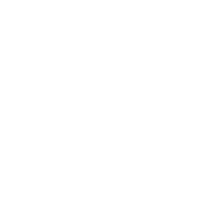

### openai/gpt-5-nano
**Time:** 0 min 19 s



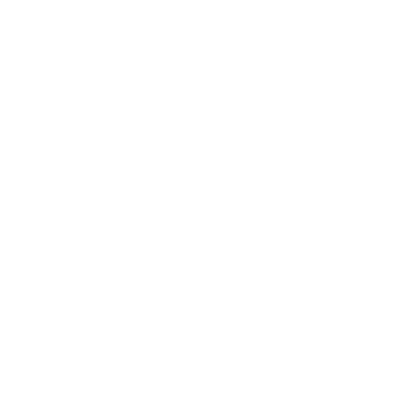

### deepseek/deepseek-reasoner
**Time:** 1 min 25 s



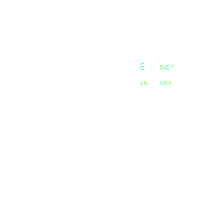

### gemini/gemini-2.5-pro
**Time:** 1 min 12 s



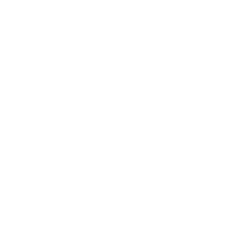

### xai/grok-4
**Time:** 0 min 26 s



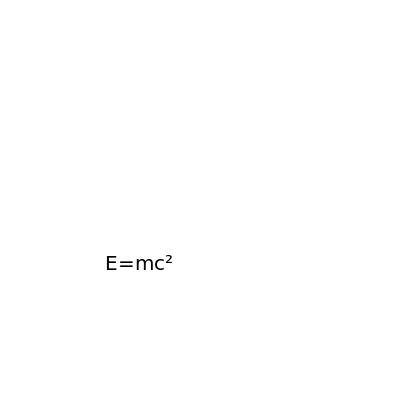

### openai/gpt-5
**Time:** 1 min 39 s



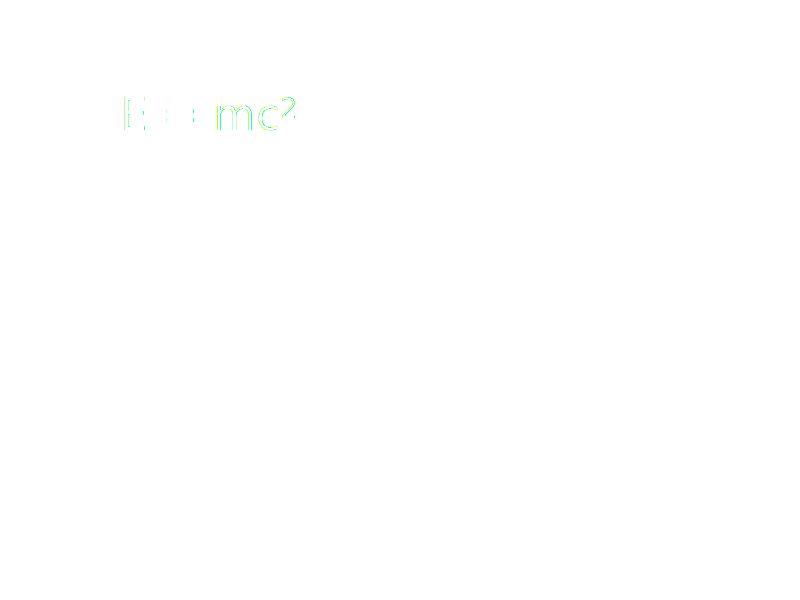

In [8]:
for result in results:
    try:
        time.sleep(5)
        display(Markdown(result[0]))
        reveal(result[1])
    except Exception as e:
        print(f"Error displaying result: {e}")
